In [1]:
%load_ext autoreload
%autoreload 2

-----
# Imports

In [18]:
import pandas as pd
import numpy as np

from deep4deep.utils_w2v_rnn import make_X_check2, my_metrics

---
# Preparing data for scoring

The files "results.csv" have been obtained by running the `preparing_results` function, 
in the "__main__", of trainer.py: 

`python -m deep4deep.trainer`

with the needed local files of data

In [4]:
# reading the NLP results
my_path = "../raw_data/data_cross_val/"
results_1 = pd.read_csv(my_path+"results_1.csv")
results_2 = pd.read_csv(my_path+"results_2.csv")
results_3 = pd.read_csv(my_path+"results_3.csv")

In [5]:
results_1.head(3)

,id,name,target,y_pred_NLP
0,890957,Swile (ex-Lunchr),0.0,0.185844
1,908268,Imcheck Therapeutics,1.0,0.716118
2,867275,Kemwatt,1.0,0.932568


In [6]:
# Adding the main model predictions on the same three sets
main_model_path = "../raw_data/data_cross_val/y_pred_(RandomForest)/"
y_pred_forest_1 = pd.read_csv(main_model_path+"y_pred1.csv")
y_pred_forest_2 = pd.read_csv(main_model_path+"y_pred2.csv")
y_pred_forest_3 = pd.read_csv(main_model_path+"y_pred3.csv")

In [7]:
# '1' is just the name of the column with probability of is_deeptech being 1, i.e. True
results_1['y_pred_forest'] = y_pred_forest_1['1']
results_2['y_pred_forest'] = y_pred_forest_2['1']
results_3['y_pred_forest'] = y_pred_forest_3['1']

---
# Computing the NLP only scores

accuracy: 79.55 %
precision: 83.61 %
recall: 71.83 %
f1: 77.27 %
Confusion matrix


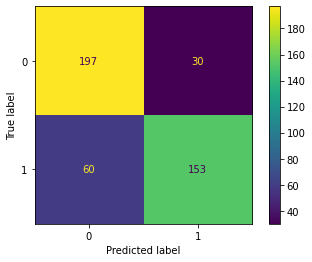

80.0	84.0	72.0	77.0
accuracy: 74.77 %
precision: 75.50 %
recall: 70.89 %
f1: 73.12 %
Confusion matrix


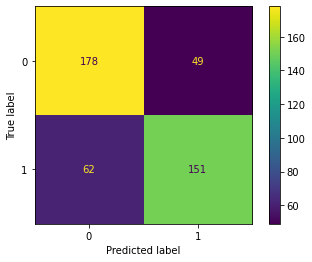

75.0	76.0	71.0	73.0
accuracy: 77.73 %
precision: 79.79 %
recall: 72.30 %
f1: 75.86 %
Confusion matrix


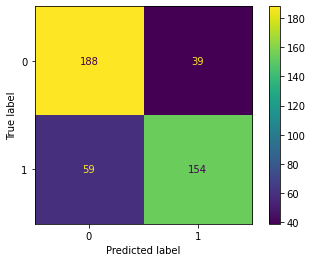

78.0	80.0	72.0	76.0


In [8]:
# using make_X_check2 function to compute metrics and convert a float to binary
# here y_pred_binary refers to the NLP prediction
NLP_d1 = my_metrics(make_X_check2(results_1, name_for_y_pred='y_pred_NLP'))
NLP_d2 = my_metrics(make_X_check2(results_2, name_for_y_pred='y_pred_NLP'))
NLP_d3 = my_metrics(make_X_check2(results_3, name_for_y_pred='y_pred_NLP'))

# the make_X_check2 function displays the metrics and the confusion matrix for each of its run, on top of returning 
# a dictionnary of metrics. Hiding ouput for subsequent runs

In [9]:
results_1.head(3)

,id,name,target,y_pred_NLP,y_pred_forest,y_pred_binary,TP,TN,FP,FN
0,890957,Swile (ex-Lunchr),0.0,0.185844,0.22,0,False,True,False,False
1,908268,Imcheck Therapeutics,1.0,0.716118,0.99,1,True,False,False,False
2,867275,Kemwatt,1.0,0.932568,0.69,1,True,False,False,False


#### Average precision over 3 NLP runs:

In [10]:
sum([NLP_d1['precision'],NLP_d2['precision'],NLP_d3['precision']])/3
# this figure was 83% using the NLP model training on the last day of the project, but went slightly lower after 
# a retraining (which is normal as it depends on the random split used)
# ultimately a retraining on the full dataset should maintain or increase the performance

0.7963310116367962

#### Average recall over 3 NLP runs:

In [11]:
# Recall
sum([NLP_d1['recall'],NLP_d2['recall'],NLP_d3['recall']])/3

0.7167449139280127

In [12]:
# Saving NLP processed results to disk
results_1.to_csv(my_path+"NLP_results_1.csv", index=False)
results_2.to_csv(my_path+"NLP_results_2.csv", index=False)
results_3.to_csv(my_path+"NLP_results_3.csv", index=False)

In [13]:
# Dropping the columns that were created and used for NLP scoring
results_1.drop(columns=['TP','TN','FP','FN', 'y_pred_binary'], inplace=True)
results_2.drop(columns=['TP','TN','FP','FN', 'y_pred_binary'], inplace=True)
results_3.drop(columns=['TP','TN','FP','FN', 'y_pred_binary'], inplace=True)

---
# Making the two models "vote" and computing general scores 

In [15]:
results_1.head(3)

,id,name,target,y_pred_NLP,y_pred_forest
0,890957,Swile (ex-Lunchr),0.0,0.185844,0.22
1,908268,Imcheck Therapeutics,1.0,0.716118,0.99
2,867275,Kemwatt,1.0,0.932568,0.69


In [16]:
# the take_measure function uses the given function as 'voting strategy'
# and only takes the main model's prediction if there is no text for NLP to vote 
#(=NLP dataset has "NaN" for the company)

def take_measure(row, function):
    if row['y_pred_NLP'] == np.nan: 
        return row['y_pred_forest']
    if function == 'mean':
        return row[['y_pred_forest','y_pred_NLP']].mean()
    if function == 'min':
        return row[['y_pred_forest','y_pred_NLP']].min()
    if function == 'max':
        return row[['y_pred_forest','y_pred_NLP']].max()
    else:
        print("not a known function")
    return None

accuracy: 80.68 %
precision: 85.16 %
recall: 72.77 %
f1: 78.48 %
Confusion matrix


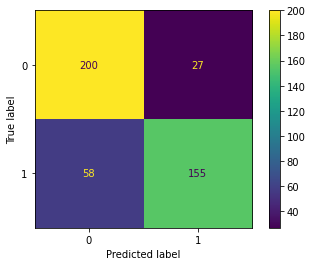

81.0	85.0	73.0	78.0
accuracy: 77.95 %
precision: 73.77 %
recall: 84.51 %
f1: 78.77 %
Confusion matrix


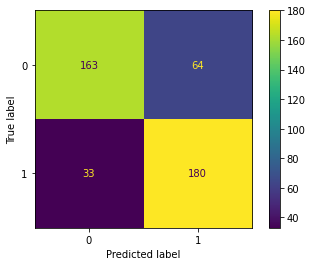

78.0	74.0	85.0	79.0
accuracy: 75.91 %
precision: 90.23 %
recall: 56.34 %
f1: 69.36 %
Confusion matrix


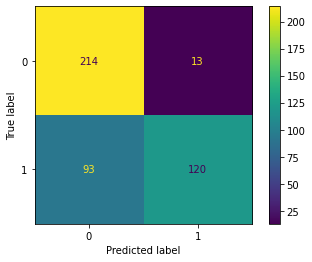

76.0	90.0	56.0	69.0


In [22]:
threshold = 0.5

# using the function for the "voting"
# then using the threhsold to convert to a "is_deeptech" yes or no prediction
results_1['y_pred_common_mean'] = results_1.apply(lambda x: take_measure(x, 'mean'), axis=1)
results_1['y_pred_common_mean_binary'] = [1 if item >threshold else 0 for item in results_1.y_pred_common_mean]

results_1['y_pred_common_max'] = results_1.apply(lambda x: take_measure(x, 'max'), axis=1)
results_1['y_pred_common_max_binary'] = [1 if item >threshold else 0 for item in results_1.y_pred_common_max]

results_1['y_pred_common_min'] = results_1.apply(lambda x: take_measure(x, 'min'), axis=1)
results_1['y_pred_common_min_binary'] = [1 if item >threshold else 0 for item in results_1.y_pred_common_min]

common_mean_d1 = my_metrics(make_X_check2(results_1, name_for_y_pred='y_pred_common_mean_binary'))
common_max_d1 = my_metrics(make_X_check2(results_1, name_for_y_pred='y_pred_common_max_binary'))
common_min_d1 = my_metrics(make_X_check2(results_1, name_for_y_pred='y_pred_common_min_binary'))

results_1.drop(columns=['y_pred_binary'], inplace=True)

In [23]:
# What "results" look like by now (transposed for legibility)
results_1.head(3).T
#

,0,1,2
id,890957,908268,867275
name,Swile (ex-Lunchr),Imcheck Therapeutics,Kemwatt
target,0,1,1
y_pred_NLP,0.185844,0.716118,0.932568
y_pred_forest,0.22,0.99,0.69
y_pred_common_mean,0.202922,0.853059,0.811284
y_pred_common_mean_binary,0,1,1
y_pred_common_max,0.22,0.99,0.932568
y_pred_common_max_binary,0,1,1
y_pred_common_min,0.185844,0.716118,0.69


In [28]:
print("Classification success metrics for run 1, using each of the 3 voting strategies, mean, max and min:")
common_mean_d1, common_max_d1, common_min_d1

Classification success metrics for run 1, using each of the 3 voting strategies, mean, max and min:


({'accuracy': 0.8068181818181818,
  'precision': 0.8516483516483516,
  'recall': 0.7276995305164319,
  'f1': 0.7848101265822784},
 {'accuracy': 0.7795454545454545,
  'precision': 0.7377049180327869,
  'recall': 0.8450704225352113,
  'f1': 0.787746170678337},
 {'accuracy': 0.759090909090909,
  'precision': 0.9022556390977443,
  'recall': 0.5633802816901409,
  'f1': 0.6936416184971097})

accuracy: 80.68 %
precision: 85.16 %
recall: 72.77 %
f1: 78.48 %
Confusion matrix


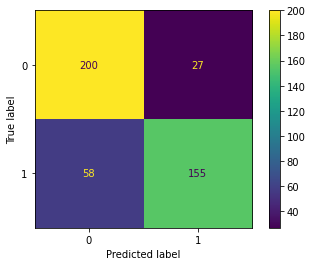

81.0	85.0	73.0	78.0
accuracy: 77.95 %
precision: 73.77 %
recall: 84.51 %
f1: 78.77 %
Confusion matrix


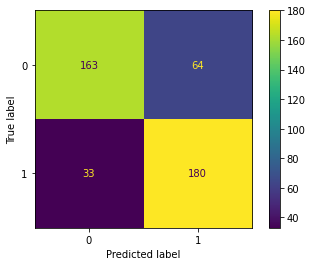

78.0	74.0	85.0	79.0
accuracy: 75.91 %
precision: 90.23 %
recall: 56.34 %
f1: 69.36 %
Confusion matrix


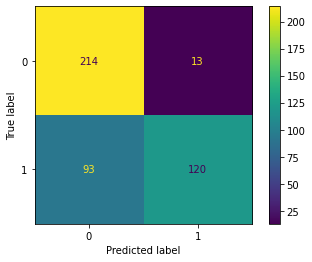

76.0	90.0	56.0	69.0


KeyError: "['y_pred_binary'] not found in axis"

In [34]:
threshold = 0.5
results_2['y_pred_common_mean'] = results_1.apply(lambda x: take_measure(x, 'mean'), axis=1)
results_2['y_pred_common_mean_binary'] = [1 if item >threshold else 0 for item in results_1.y_pred_common_mean]

results_2['y_pred_common_max'] = results_1.apply(lambda x: take_measure(x, 'max'), axis=1)
results_2['y_pred_common_max_binary'] = [1 if item >threshold else 0 for item in results_1.y_pred_common_max]

results_2['y_pred_common_min'] = results_1.apply(lambda x: take_measure(x, 'min'), axis=1)
results_2['y_pred_common_min_binary'] = [1 if item >threshold else 0 for item in results_1.y_pred_common_min]

common_mean_d2 = my_metrics(make_X_check2(results_1, name_for_y_pred='y_pred_common_mean_binary'))
common_max_d2 = my_metrics(make_X_check2(results_1, name_for_y_pred='y_pred_common_max_binary'))
common_min_d2 = my_metrics(make_X_check2(results_1, name_for_y_pred='y_pred_common_min_binary'))

results_2.drop(columns=['y_pred_binary'], inplace=True)

In [35]:
print("Classification success metrics for run 2:")
common_mean_d2, common_max_d2, common_min_d2

Classification success metrics for run 2:


({'accuracy': 0.8068181818181818,
  'precision': 0.8516483516483516,
  'recall': 0.7276995305164319,
  'f1': 0.7848101265822784},
 {'accuracy': 0.7795454545454545,
  'precision': 0.7377049180327869,
  'recall': 0.8450704225352113,
  'f1': 0.787746170678337},
 {'accuracy': 0.759090909090909,
  'precision': 0.9022556390977443,
  'recall': 0.5633802816901409,
  'f1': 0.6936416184971097})

accuracy: 80.45 %
precision: 81.59 %
recall: 77.00 %
f1: 79.23 %
Confusion matrix


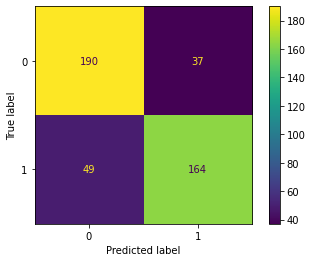

80.0	82.0	77.0	79.0
accuracy: 74.32 %
precision: 68.12 %
recall: 88.26 %
f1: 76.89 %
Confusion matrix


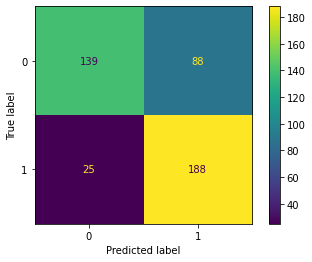

74.0	68.0	88.0	77.0
accuracy: 77.27 %
precision: 91.85 %
recall: 58.22 %
f1: 71.26 %
Confusion matrix


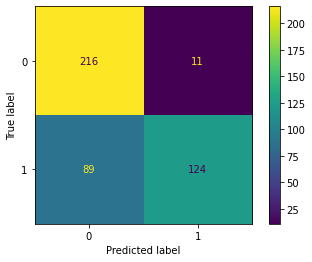

77.0	92.0	58.0	71.0


In [36]:
threshold = 0.5
results_3['y_pred_common_mean'] = results_3.apply(lambda x: take_measure(x, 'mean'), axis=1)
results_3['y_pred_common_mean_binary'] = [1 if item >threshold else 0 for item in results_3.y_pred_common_mean]

results_3['y_pred_common_max'] = results_3.apply(lambda x: take_measure(x, 'max'), axis=1)
results_3['y_pred_common_max_binary'] = [1 if item >threshold else 0 for item in results_3.y_pred_common_max]

results_3['y_pred_common_min'] = results_3.apply(lambda x: take_measure(x, 'min'), axis=1)
results_3['y_pred_common_min_binary'] = [1 if item >threshold else 0 for item in results_3.y_pred_common_min]

common_mean_d3 = my_metrics(make_X_check2(results_3, name_for_y_pred='y_pred_common_mean_binary'))
common_max_d3 = my_metrics(make_X_check2(results_3, name_for_y_pred='y_pred_common_max_binary'))
common_min_d3 = my_metrics(make_X_check2(results_3, name_for_y_pred='y_pred_common_min_binary'))

results_3.drop(columns=['y_pred_binary'], inplace=True)

In [37]:
print("Classification success metrics for run 3:")
common_mean_d3, common_max_d3, common_min_d3

Classification success metrics for run 3:


({'accuracy': 0.8045454545454546,
  'precision': 0.8159203980099502,
  'recall': 0.7699530516431925,
  'f1': 0.7922705314009663},
 {'accuracy': 0.7431818181818182,
  'precision': 0.6811594202898551,
  'recall': 0.8826291079812206,
  'f1': 0.768916155419223},
 {'accuracy': 0.7727272727272727,
  'precision': 0.9185185185185185,
  'recall': 0.5821596244131455,
  'f1': 0.7126436781609196})

### On the three runs, 'min' is the best 'voting approach' for maximizing precision.
#### Scores with 'min' used as 'voting approach' between the tow models (main model and NLP): 

In [38]:
global_precision_min = (common_min_d1['precision']+common_min_d2['precision']+common_min_d3['precision'])/3
global_precision_min
# again, the value was 91% when we did the calculation on the last day of the project, 
# it can vary slightly with repetition

0.907676598904669

In [39]:
global_recall_min = (common_min_d1['recall']+common_min_d2['recall']+common_min_d3['recall'])/3
global_recall_min

0.5696400625978091

#### Scores with max
Max allows to maximize recall instead of precision, while mean strikes a balance

In [40]:
global_precision_max = (common_max_d1['precision']+common_max_d2['precision']+common_max_d3['precision'])/3
global_precision_max

0.7188564187851431

In [41]:
global_recall_max = (common_max_d1['recall']+common_max_d2['recall']+common_max_d3['recall'])/3
global_recall_max

0.8575899843505477

---


In [42]:
# Saving processed results to disk
results_1.to_csv(my_path+"voting_results_1.csv", index=False)
results_2.to_csv(my_path+"voting_results_2.csv", index=False)
results_3.to_csv(my_path+"voting_results_3.csv", index=False)